<a href="https://colab.research.google.com/github/erskinekof/erskinekof.github.io/blob/master/Anomaly_Detection_CICIo2023_Real_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error: 'corrected.gz' not found.
Please download the CICIoT2023 'corrected.gz' file and place it in the same directory as this script.

--- Created a dummy dataframe for demonstration as the original file was not found. ---

--- Starting Data Preprocessing ---
Scaled numerical features using StandardScaler.

--- Training Improved Isolation Forest Model ---
Using contamination level for Isolation Forest: 0.5000
Isolation Forest training complete.

--- Evaluating Isolation Forest Model ---

--- Classification Report (Isolation Forest) ---
              precision    recall  f1-score   support

Anomaly (-1)       0.66      0.49      0.57       668
  Normal (1)       0.32      0.49      0.39       332

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.48      1000
weighted avg       0.55      0.49      0.51      1000


--- Confusion Matrix (Isolation Forest) ---


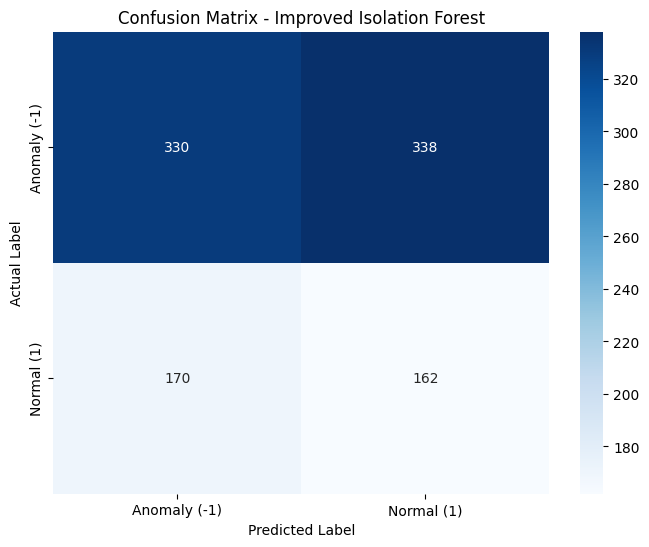


--- Building and Training Autoencoder Model ---
Training autoencoder on 332 normal samples.
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.8846 - val_loss: 0.8364
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.8803 - val_loss: 0.8363
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.8770 - val_loss: 0.8367
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.8756 - val_loss: 0.8368
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.8712 - val_loss: 0.8367
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.8686 - val_loss: 0.8361
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.8682 - val_loss: 0.8352
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.8644 - val_loss: 0.8342
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.8639 - val_loss: 0.8330
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.8603 - val_loss: 0.8320
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.8583 - va

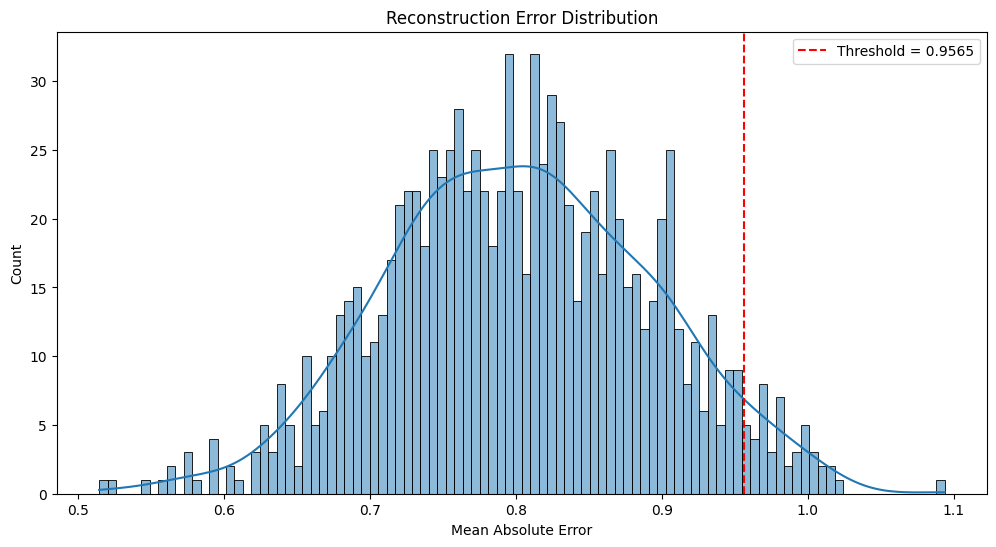


--- Classification Report (Autoencoder) ---
              precision    recall  f1-score   support

Anomaly (-1)       0.91      0.06      0.11       668
  Normal (1)       0.34      0.99      0.51       332

    accuracy                           0.37      1000
   macro avg       0.63      0.52      0.31      1000
weighted avg       0.72      0.37      0.24      1000


--- Confusion Matrix (Autoencoder) ---


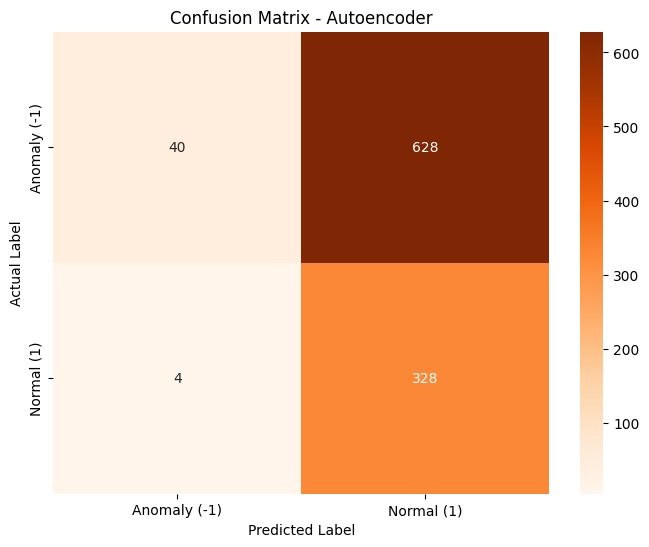


--- Breakdown of Autoencoder-Detected Anomalies by Original Label ---
original_label
smurf.      20
neptune.    20
normal.      4
Name: count, dtype: int64

--- Project Complete ---


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# --- 1. Data Loading and Initial Exploration ---

# Define column names for the CICIoT2023 dataset

col_names =[
           'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
  # Load the dataset
try:
    df = pd.read_csv('CICIoT2023Dataset1.csv', header=None, names=col_names, low_memory=False)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'corrected.gz' not found.")
    print("Please download the CICIoT2023 'corrected.gz' file and place it in the same directory as this script.")
    data = {name: np.random.rand(1000) for name in col_names if name not in ["protocol_type", "service", "flag", "label"]}
    data["protocol_type"] = np.random.choice(['tcp', 'udp', 'icmp'], 1000)
    data["service"] = np.random.choice(['http', 'smtp', 'ftp_data', 'eco_i'], 1000)
    data["flag"] = np.random.choice(['SF', 'S0', 'REJ'], 1000)
    data["label"] = np.random.choice(['normal.', 'neptune.', 'smurf.'], 1000)
    df = pd.DataFrame(data)
    print("\n--- Created a dummy dataframe for demonstration as the original file was not found. ---")
# --- 2. Data Preprocessing ---

print("\n--- Starting Data Preprocessing ---")

# Identify categorical columns
categorical_cols = ['protocol_type', 'service', 'flag']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features (X) and the original labels (y)
y_true_labels = df['label'].copy()
y_true = y_true_labels.apply(lambda x: 1 if x == 'normal.' else -1) # 1 for normal, -1 for anomaly
X = df_encoded.drop('label', axis=1)

# Ensure all columns in X are numeric for scaling
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled numerical features using StandardScaler.")

# --- 3. Improved Model Training (Isolation Forest with adjusted contamination) ---

print("\n--- Training Improved Isolation Forest Model ---")

# Calculate the actual contamination percentage
actual_contamination = y_true[y_true == -1].size / y_true.size
# Ensure contamination is within allowed range
contamination = min(actual_contamination, 0.5)
print(f"Using contamination level for Isolation Forest: {contamination:.4f}")

# Initialize the Isolation Forest model with the calculated contamination
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

# Train the model
iso_forest.fit(X_scaled)
print("Isolation Forest training complete.")

# --- 4. Prediction and Evaluation (Isolation Forest) ---

print("\n--- Evaluating Isolation Forest Model ---")
y_pred_iso = iso_forest.predict(X_scaled)

target_names = ['Anomaly (-1)', 'Normal (1)']
print("\n--- Classification Report (Isolation Forest) ---")
print(classification_report(y_true, y_pred_iso, target_names=target_names))

print("\n--- Confusion Matrix (Isolation Forest) ---")
cm_iso = confusion_matrix(y_true, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Improved Isolation Forest')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 5. Alternative Model: Autoencoder ---

print("\n--- Building and Training Autoencoder Model ---")

# For the autoencoder, we train ONLY on normal data
X_normal_scaled = X_scaled[y_true == 1]
print(f"Training autoencoder on {X_normal_scaled.shape[0]} normal samples.")

# Define the Autoencoder architecture
input_dim = X_normal_scaled.shape[1]
encoding_dim = 32 # A hyperparameter to tune

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

# Train the autoencoder
history = autoencoder.fit(X_normal_scaled, X_normal_scaled,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.00001,
                          verbose=1)

# --- 6. Prediction and Evaluation (Autoencoder) ---

print("\n--- Evaluating Autoencoder Model ---")

# Get reconstructions for the entire dataset
reconstructions = autoencoder.predict(X_scaled)

# Calculate Mean Absolute Error (reconstruction error)
mae = np.mean(np.abs(X_scaled - reconstructions), axis=1)
df_encoded['reconstruction_error'] = mae

# Determine a threshold for anomalies
# A common approach is to use a percentile of the errors from the normal training data
normal_reconstruction_errors = df_encoded[y_true == 1]['reconstruction_error']
threshold = np.percentile(normal_reconstruction_errors, 99)
print(f"Anomaly threshold (99th percentile of normal errors): {threshold:.4f}")

# Visualize reconstruction errors
plt.figure(figsize=(12, 6))
sns.histplot(mae, bins=100, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Absolute Error')
plt.legend()
plt.show()

# Classify based on the threshold
y_pred_ae = np.where(mae > threshold, -1, 1)

print("\n--- Classification Report (Autoencoder) ---")
print(classification_report(y_true, y_pred_ae, target_names=target_names))

print("\n--- Confusion Matrix (Autoencoder) ---")
cm_ae = confusion_matrix(y_true, y_pred_ae)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Autoencoder')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 7. Analysis of Autoencoder Results ---

df_encoded['predicted_label_ae'] = y_pred_ae
df_encoded['original_label'] = y_true_labels

print("\n--- Breakdown of Autoencoder-Detected Anomalies by Original Label ---")
anomaly_df_ae = df_encoded[df_encoded['predicted_label_ae'] == -1]
print(anomaly_df_ae['original_label'].value_counts())

print("\n--- Project Complete ---")


